<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Pipeline/Pipeline_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [0]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
# Seed value
# Apparently you may use different seed values at each stage
#seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
#import os
#os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
#import random
#random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
#import numpy as np
#np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
#import tensorflow as tf
#tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

#Load data

In [157]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
public_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_labels = df_train.Histology

In [0]:
PA_labels = df_test.Histology

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(public_data, public_labels, test_size=0.3, stratify=public_labels, random_state=3)

In [169]:
X_train.shape

(91, 107)

#Vettorizzare i label

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(y_train)
test_labels_encoded = encoder.transform(y_test)

#Scalers

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

In [0]:
scalers_to_test = [StandardScaler(), RobustScaler()]

#DecisionTreeClassifier 

In [0]:
from sklearn.tree import DecisionTreeClassifier 

In [0]:
steps = [('scaler', StandardScaler()), ('red_dim', LinearDiscriminantAnalysis()), ('clf', DecisionTreeClassifier(random_state=0))]

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
n_features_to_test = np.arange(1, 11)

In [0]:
parameteres = [{'scaler':scalers_to_test, 'red_dim':[LinearDiscriminantAnalysis()], 'red_dim__n_components':[2], 'clf__criterion':['gini', 'entropy']},
               {'scaler':scalers_to_test, 'red_dim':[PCA()], 'red_dim__n_components':n_features_to_test, 'clf__criterion':['gini', 'entropy']}]

In [0]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, verbose=1)

In [217]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    5.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('red_dim',
                                        LinearDiscriminantAnalysis(n_components=None,
                                                                   priors=None,
                                                                   shrinkage=None,
                                                                   solver='svd',
                                                                   store_covariance=False,
                                                                   tol=0.0001)),
                                       ('clf',
                                        DecisionTreeClassifi

In [219]:
print(f'score = {grid.score(X_test, y_test)}')

score = 0.4


In [220]:
print(grid.best_params_)

{'clf__criterion': 'gini', 'red_dim': PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'red_dim__n_components': 5, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


#SVM

In [0]:
from sklearn.svm import SVC

In [0]:
steps = [('scaler', StandardScaler()), ('red_dim', PCA()), ('clf', SVC(random_state=1))]

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

In [0]:
parameteres = [{'scaler':scalers_to_test, 'red_dim':[PCA()], 'red_dim__n_components':[9],'clf__C':[0.001,0.1,10], 'clf__kernel':['linear', 'rbf', 'sigmoid'], 'clf__gamma':[0.1,0.01]},
               {'scaler':scalers_to_test, 'red_dim':[PCA()], 'red_dim__n_components':[9],'clf__C':[0.001,0.1,10], 'clf__kernel':['poly'], 'clf__degree':[1,2,3,4], 'clf__gamma':[0.1,0.01]}]

In [0]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

In [0]:
grid = RandomizedSearchCV(pipeline, param_distributions=parameteres, n_iter =50, cv=5, verbose=10, n_jobs=-1, scoring='accuracy')
#per questo usare parentesi tonde per i kernel

In [0]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, verbose=10, n_jobs=-1, scoring='accuracy')
#per questo usare parentesi quadre per i kernel

In [0]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0293s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1098s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Batch computation too slow (23.5681s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1824s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1262s.) Setting batch_size=4.
[Parallel(n_

KeyboardInterrupt: ignored

In [248]:
print(f'score = {grid.score(X_test, y_test)}')

score = 0.45


In [249]:
print(grid.best_params_)

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'red_dim__n_components': 9, 'red_dim': PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'clf__kernel': 'linear', 'clf__gamma': 0.01, 'clf__C': 0.001}


##Validation curve

In [0]:
plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(n_estimators, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n_estimators, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(n_estimators, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n_estimators, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

#RandomForestClassifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
steps = [('scaler', StandardScaler()), ('red_dim', PCA()), ('clf', RandomForestClassifier(random_state=0))]

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

In [0]:
n_tree = np.arange(10, 120, 10)

In [0]:
n_tree = list(n_tree)

In [0]:
parameteres = [{'scaler':scalers_to_test, 'red_dim':[LinearDiscriminantAnalysis()], 'red_dim__n_components':[2], 'clf__n_estimators':n_tree},
               {'scaler':scalers_to_test, 'red_dim':[PCA()], 'red_dim__n_components':n_features_to_test, 'clf__n_estimators':n_tree}]

In [0]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

In [0]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, verbose=1)

In [120]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 242 candidates, totalling 1210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1210 out of 1210 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('red_dim',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_

In [121]:
print(f'score = {grid.score(X_test, y_test)}')

score = 0.475


In [122]:
print(grid.best_params_)

{'clf__n_estimators': 90, 'red_dim': PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'red_dim__n_components': 9, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


{'scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True), 'red_dim__n_components': 7, 'red_dim': PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'clf__n_estimators': 60}

  score=0.65

##Prova con i best params

In [0]:
r_scaler = RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True)
s_scaler = StandardScaler()

In [0]:
X_train_scaled = s_scaler.fit_transform(X_train)
X_test_scaled = s_scaler.transform(X_test)

In [0]:
X_train_scaled = r_scaler.fit_transform(X_train)
X_test_scaled = r_scaler.transform(X_test)

In [0]:
pca = PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [0]:
rfc = RandomForestClassifier(random_state=0, n_estimators=1200)

In [180]:
rfc.fit(X_train_scaled_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [181]:
rfc.score(X_test_scaled_pca, y_test)

0.55

In [0]:
from sklearn.model_selection import validation_curve

np.random.seed(2)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

train_scores, valid_scores = validation_curve(RandomForestClassifier(), X_train_scaled_pca, y_train, "n_estimators", n_estimators, scoring="accuracy", cv=5)

In [0]:
indices = np.arange(y_train.shape[0])

In [199]:
train_scores.shape

(10, 5)

In [0]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

In [201]:
train_scores_mean.shape

(10,)

###Validation curve

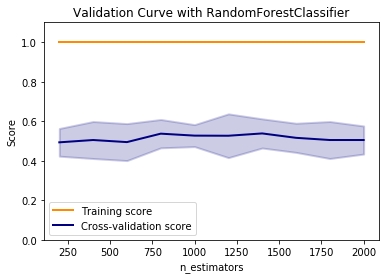

In [202]:
plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(n_estimators, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(n_estimators, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(n_estimators, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(n_estimators, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

###Learning curve

In [204]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


Automatically created module for IPython interactive environment


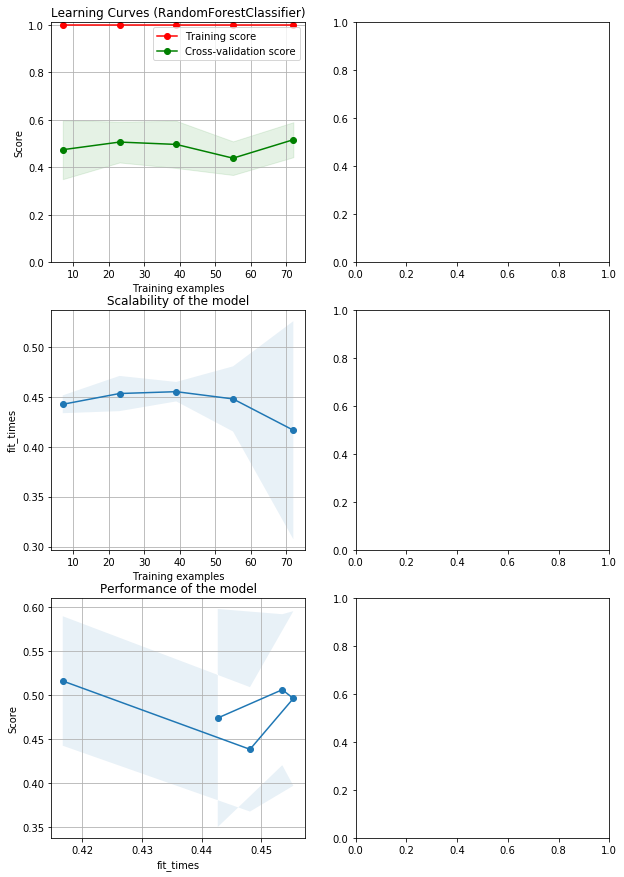

In [206]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (RandomForestClassifier)"

estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X_train_scaled_pca, y_train, axes=axes[:, 0], ylim=(0.0, 1.01), cv=5, n_jobs=4)

plt.show()

#G_search 

In [124]:
from sklearn.model_selection import RandomizedSearchCV # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
              
              
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [138]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train_scaled_pca, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [128]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [129]:
rf_random.score(X_test, y_test)

0.5

#KNeighborsClassifier

In [0]:
from sklearn.neighbors import KNeighborsClassifier
steps = [('scaler', StandardScaler()), ('red_dim', PCA()), ('clf', KNeighborsClassifier())]

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

n_features_to_test = np.arange(1, 11)
parameteres = [{'scaler':scalers_to_test, 'red_dim':[LinearDiscriminantAnalysis()], 'red_dim__n_components':[2], 'clf__n_neighbors':n_features_to_test, 'clf__weights':['uniform', 'distance'], 'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
               {'scaler':scalers_to_test, 'red_dim':[PCA()], 'red_dim__n_components':n_features_to_test, 'clf__n_neighbors':n_features_to_test, 'clf__weights':['uniform', 'distance'], 'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}]

from sklearn.model_selection import GridSearchCV 
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, verbose=1)



In [0]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1760 candidates, totalling 8800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 8800 out of 8800 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('red_dim',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='min

In [0]:
print(f'score = {grid.score(X_test, y_test)}')

score = 0.5


In [0]:
print(grid.best_params_)

{'clf__algorithm': 'auto', 'clf__n_neighbors': 10, 'clf__weights': 'uniform', 'red_dim': PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'red_dim__n_components': 3, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [0]:
from sklearn.model_selection import RandomizedSearchCV
grid = RandomizedSearchCV(pipeline, param_distributions=parameteres, n_iter=100, cv=5, verbose=1)


In [0]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.5s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('red_dim',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('clf',
                                              KNeighborsClassifier(algorithm='auto',
             

In [0]:
print(f'score = {grid.score(X_test, y_test)}')
print(grid.best_params_)

score = 0.55
{'scaler': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True), 'red_dim__n_components': 5, 'red_dim': PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'clf__weights': 'uniform', 'clf__n_neighbors': 9, 'clf__algorithm': 'auto'}


#RadiusNeighborsClassifier

In [0]:
from sklearn.neighbors import RadiusNeighborsClassifier
steps = [('scaler', StandardScaler()), ('red_dim', PCA()), ('clf', RadiusNeighborsClassifier(outlier_label='most_frequent'))]

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

R = np.arange(0.5, 5, 0.5) 
n_features_to_test = np.arange(1, 11)
parameteres = [{'scaler':scalers_to_test, 'red_dim':[LinearDiscriminantAnalysis()], 'red_dim__n_components':[2], 'clf__radius':R, 'clf__weights':['uniform', 'distance'], 'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
               {'scaler':scalers_to_test, 'red_dim':[PCA()], 'red_dim__n_components':n_features_to_test, 'clf__radius':R, 'clf__weights':['uniform', 'distance'], 'clf__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}]

from sklearn.model_selection import GridSearchCV 
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, verbose=1)

In [0]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1584 candidates, totalling 7920 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 7920 out of 7920 | elapsed:  3.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('red_dim',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        RadiusNeighborsClassifier(algorithm='auto',
                                                                  leaf_size=30,
                                                              

In [0]:
print(f'score = {grid.score(X_test, y_test)}')
print(grid.best_params_)

score = 0.6
{'clf__algorithm': 'auto', 'clf__radius': 4.5, 'clf__weights': 'uniform', 'red_dim': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'red_dim__n_components': 2, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [0]:
R

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

#AdaBoostClassifier

In [0]:
from sklearn.ensemble import AdaBoostClassifier
steps = [('scaler', StandardScaler()), ('red_dim', PCA()), ('clf', AdaBoostClassifier(random_state=1))]

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

n_features_to_test = np.arange(1, 11)
n_estimators = np.arange(20, 120, 10)
lr = np.arange(0.2, 3, 0.2  )
parameteres = [{'scaler':scalers_to_test, 'red_dim':[LinearDiscriminantAnalysis()], 'red_dim__n_components':[2], 'clf__n_estimators':n_estimators, 'clf__learning_rate':lr, 'clf__algorithm':['SAMME', 'SAMME.R']},
               {'scaler':scalers_to_test, 'red_dim':[PCA()], 'red_dim__n_components':n_features_to_test, 'clf__n_estimators':n_estimators, 'clf__learning_rate':lr, 'clf__algorithm':['SAMME', 'SAMME.R']}]

from sklearn.model_selection import GridSearchCV 
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5, verbose=1)


In [0]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6160 candidates, totalling 30800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true

KeyboardInterrupt: ignored

In [0]:
print(f'score = {grid.score(X_test, y_test)}')
print(grid.best_params_)

#LinearDiscriminantAnalysis

#LogisticRegression